In [15]:
#Load Libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [16]:
#Import Data:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [17]:
#Set Randomstate:
rs = 42

In [18]:
#Some pre-processing:
y_train = train['label']
train.drop(labels=["label"], axis=1, inplace=True) 

#Reshaping:
train = train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

#Normalization:
train = train / 255.0
test = test / 255.0

#Set Categories:
y_train = to_categorical(y_train, num_classes = 10)

In [19]:
# Split the train and the validation sets:
X_train, X_val, Y_train, Y_val = train_test_split(train, y_train, test_size = 0.1, random_state=rs)

In [20]:
# Set the CNN model:

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = 3,padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = 3,padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = 5, strides = 2, padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(filters = 64, kernel_size = 3,padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = 3,padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = 5, strides = 2, padding = 'Same', 
                 activation ='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size = 4, activation='relu')) 
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [21]:
# Set a learning rate annealer:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.000001)

epochs = 30
batch_size = 128

In [22]:
#Employ data augmentation:
datagen = ImageDataGenerator( 
        rotation_range=10,
        zoom_range = 0.10,
        width_shift_range=0.1,
        height_shift_range=0.1)

datagen.fit(X_train)

In [23]:
#Training!:
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/30
 - 129s - loss: 0.4810 - accuracy: 0.8520 - val_loss: 11.9007 - val_accuracy: 0.0962
Epoch 2/30
 - 131s - loss: 0.1367 - accuracy: 0.9598 - val_loss: 0.0909 - val_accuracy: 0.9717
Epoch 3/30
 - 128s - loss: 0.1064 - accuracy: 0.9690 - val_loss: 0.0619 - val_accuracy: 0.9862
Epoch 4/30
 - 129s - loss: 0.0912 - accuracy: 0.9734 - val_loss: 0.0380 - val_accuracy: 0.9893
Epoch 5/30
 - 128s - loss: 0.0764 - accuracy: 0.9776 - val_loss: 0.0427 - val_accuracy: 0.9905
Epoch 6/30
 - 129s - loss: 0.0727 - accuracy: 0.9791 - val_loss: 0.0465 - val_accuracy: 0.9888
Epoch 7/30
 - 127s - loss: 0.0646 - accuracy: 0.9822 - val_loss: 0.0477 - val_accuracy: 0.9890

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 8/30
 - 130s - loss: 0.0483 - accuracy: 0.9859 - val_loss: 0.0319 - val_accuracy: 0.9886
Epoch 9/30
 - 128s - loss: 0.0406 - accuracy: 0.9882 - val_loss: 0.0278 - val_accuracy: 0.9921
Epoch 10/30
 - 130s - loss: 0.0386 - accuracy: 0.9883 - val_los

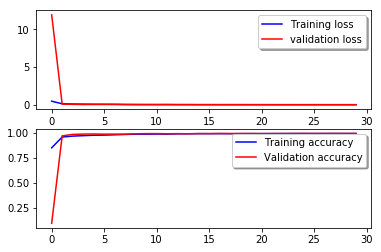

In [25]:
# Plot the loss and accuracy curves for training and validation: 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [26]:
#Predict:
results = model.predict(test)

#Select prediction with maximum probability:
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [27]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("test_pred.csv",index=False)

In [28]:
#Save model:
model.save('my_model', save_format="tf")

In [1]:
#Convert to TFLite format for deployment:
converter = tf.lite.TFLiteConverter.from_saved_model("my_model")
tflite_model = converter.convert()

NameError: name 'tf' is not defined